# Graded exercise: Constraining Models

Blue Brain Project / EPFL ©2005-2017. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.

## Problem description

Based on the ball-and-stick ipython notebook, write a new optimisation according to the following criteria:

**NOTE**: there are some detailed changes compared to the main tutorial notebook, beware of the details in the description below (most important changes: morphology, no dendritic channels)

- Use the **morphology** 'ballandstick.swc2' defined in the code below. Do **not** use the morphology from the tutorial notebook.
- Add the **hh** mechanism **only** to the soma ('somatic' section list). Do **not** add it to the dendrites.
- Use the parameters **gnabar_hh** (bounds  [0.05, 0.125]) and **gkbar_hh** (bounds [0.01, 0.05]) in the **soma**.
- **Add** an **extra parameter 'gl_hh'** in the **soma**. This represent the size of the leak current in the 'hh' mechanism of NEURON. The **bounds** of this parameter should be **[1e-4, 5e-4]**.
- **Add** two positive step current injections, amplitudes 0.1 nA and 0.5 nA, both a with delay 100ms and duration 50ms. Set the total_duration to 200 ms.
- To constrain the leak parameter better, we will include **an extra stimulus with negative current amplitude** to the protocol (on top of the existing current injections). The step current injected should have an **amplitude** of **-0.3 nA**. For delay, duration and total_duration use the same as for the first two stimuli.
- For each stimulus create a SweepProtocol that **records** the voltage from the soma.
- Combine these SweepProtocols into a SequenceProtocol.
- For the two positive current injections set a target mean of the SpikeCount feature to 1 and 5 respectively.
- For the trace generated by the negative current injection, **use the efeature** **'steady_state_voltage_stimend'**, and set its **mean to -100 mV**.
- For the exp_std of the features use 0.05 * abs(mean).
- Run the optimisation with an **offspring_size of 30**, and **10 generations**.

Run this optimisation, and send us the parameters of the best individual.

You will get a grade of 1.0 if the scores for the three features are all 0 <= score <=3.

## Solution

simple_cell:
  morphology:
    ballandstick2.swc
  mechanisms:
    hh: hh at ['somatic']
  params:
    gnabar_soma: ['somatic'] gnabar_hh = [0.05, 0.125]
    gkbar_soma: ['somatic'] gkbar_hh = [0.01, 0.05]
    gl_soma: ['somatic'] gl_hh = [0.0001, 0.0005]



Exception: Traceback (most recent call last):
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/bluepyopt/ephys/protocols.py", line 130, in _run_func
    cell_model.instantiate(sim=sim)
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/bluepyopt/ephys/models.py", line 227, in instantiate
    param.instantiate(sim=sim, icell=self.icell)
  File "/opt/conda/envs/python2/lib/python2.7/site-packages/bluepyopt/ephys/parameters.py", line 197, in instantiate
    'without value' % self.name)
Exception: NrnSectionParameter: impossible to instantiate parameter "gl_soma" without value


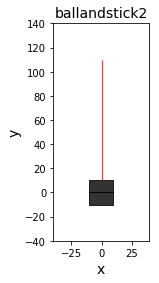

In [1]:
import os
os.unsetenv('PYTHONHOME') # Solve an issue with NEURON simulator import
!pip install -q bluepyopt==1.5.12 matplotlib==2.0.2 numpy==1.13.0 2>&1 | grep -v 'SNIMissingWarning\|InsecurePlatformWarning'
!pip install -q --upgrade --pre -i https://bbpteam.epfl.ch/repository/devpi/simple/ single-cell-mooc-client

%matplotlib inline
import matplotlib.pyplot as plt
import bluepyopt as bpop
import bluepyopt.ephys as ephys

morph_swc_string2 = """
1 1 0.0 -10.0 0.0 10.0 -1                                                        
2 1 0.0 0.0 0.0 10.0 1                                                           
3 1 0.0 10.0 0.0 10.0 2                                                          
4 3 0.0 10.0 0.0 2.0 1                                                           
5 3 0.0 110.0 0.0 2.0 4
"""

with open('ballandstick2.swc', 'w') as swc_file:
    swc_file.write(morph_swc_string2)

# We can plot this morphology using the Neuronal Morphology Analysis Tool (NeuroM)

import neurom
import neurom.viewer
fig, ax = neurom.viewer.draw(neurom.load_neuron('ballandstick2.swc'))

# To use this morphology in BluePyOpt we create a NrnFileMorphology object

morph = ephys.morphologies.NrnFileMorphology('ballandstick2.swc')

somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')
# dend_loc = ephys.locations.NrnSeclistLocation('basal', seclist_name='basal')

## Creating a mechanism
# The NEURON simulator has a builtin implementation of the Hodgkin-Huxley Sodium (Na), 
# Potassium (K) and leak channels. Let's add this mechanism (called 'hh') to the soma.

# Add the hh mechanism only to the soma ('somatic' section list). Do not add it to the dendrites.
hh_mech = ephys.mechanisms.NrnMODMechanism(
        name='hh',
        suffix='hh',
        locations=[somatic_loc])

## Creating parameters
# Use the parameters gnabar_hh (bounds [0.05, 0.125]) and gkbar_hh (bounds [0.01, 0.05]) in the soma.
gnabar_soma = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_soma',
        param_name='gnabar_hh',
        locations=[somatic_loc],
        bounds=[0.05, 0.125],
        frozen=False)     
gkbar_soma = ephys.parameters.NrnSectionParameter(
        name='gkbar_soma',
        param_name='gkbar_hh',
        bounds=[0.01, 0.05],
        locations=[somatic_loc],
        frozen=False)

# Add an extra parameter 'gl_hh' in the soma. This represent the size of the leak current in the 'hh' mechanism of NEURON. 
# The bounds of this parameter should be [1e-4, 5e-4].
gl_soma = ephys.parameters.NrnSectionParameter(
        name='gl_soma',
        param_name='gl_hh',
        bounds=[1e-4, 5e-4],
        locations=[somatic_loc],
        frozen=False)

# Creating the cell model

ballandstick_cell = ephys.models.CellModel(
        name='simple_cell',
        morph=morph,
        mechs=[hh_mech],
        params=[gnabar_soma, gkbar_soma, gl_soma]) 

print(ballandstick_cell)

## Setting up a cell evaluator
# Creating the protocols

soma_loc = ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5)

# Add two positive step current injections, amplitudes 0.1 nA and 0.5 nA, both a with delay 100ms and duration 50ms. 
# Set the total_duration to 200 ms.

# The step current injected should have an amplitude of -0.3 nA. 

sweep_protocols = []
for protocol_name, amplitude in [('step1', 0.1), ('step2', 0.5), ('step3', -0.3) ]:
    stim = ephys.stimuli.NrnSquarePulse(
                step_amplitude=amplitude,
                step_delay=100,
                step_duration=50,
                location=soma_loc,
                total_duration=200)
    rec = ephys.recordings.CompRecording(
            name='%s.soma.v' % protocol_name,
            location=soma_loc,
            variable='v')
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

# Running a protocol on a cell

nrn = ephys.simulators.NrnSimulator()

# default_params = {'gnabar_soma': 0.05, 'gkbar_soma': 0.01}

# responses = twostep_protocol.run(cell_model=ballandstick_cell, param_values=default_params, sim=nrn)

# def plot_responses(responses):
#     plt.subplot(2,1,1)
#     plt.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='step1')
#     plt.legend()
#     plt.subplot(2,1,2)
#     plt.plot(responses['step2.soma.v']['time'], responses['step2.soma.v']['voltage'], label='step2')
#     plt.legend()
#     plt.tight_layout()

# plot_responses(responses)

# - For the two positive current injections set a target mean of the SpikeCount feature to 1 and 5 respectively.
# - For the trace generated by the negative current injection, **use the efeature** **'steady_state_voltage_stimend'**, 
# and set its **mean to -100 mV**.
# - For the exp_std of the features use 0.05 * abs(mean).

# Defining eFeatures and objectives

efel_feature_means = {'step1': {'Spikecount': 1}, 'step2': {'Spikecount': 5},'step3':{'steady_state_voltage_stimend':-100}}

objectives = []
features = []

for protocol in sweep_protocols:
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration
    for efel_feature_name, mean in efel_feature_means[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.soma.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.05 * abs(mean))
        features.append(feature)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            feature)
        objectives.append(objective)

score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives) 
cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model=ballandstick_cell,
        param_names=['gnabar_soma', 'gkbar_soma'],
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc,
        sim=nrn)

# print 'Scores:', cell_evaluator.evaluate_with_dicts(default_params)

## Setting up and running an optimisation

# - Run the optimisation with an **offspring_size of 30**, and **10 generations**.
optimisation_algorithm_ex = bpop.deapext.optimisations.IBEADEAPOptimisation(
        evaluator=cell_evaluator,
        offspring_size = 30)

final_pop_ex, hall_of_fame_ex, logs_ex, hist_ex = optimisation_algorithm_ex.run(max_ngen=10)


# An example answer of the expected output
best_ind_dict_ex = {'gl_hh': 0.0, 'gnabar_hh': 0.0, 'gkbar_hh': 0.0}
answer = '%f,%f,%f' % (best_ind_dict_ex['gnabar_hh'], best_ind_dict_ex['gkbar_hh'], best_ind_dict_ex['gl_hh'])
print('Answer: %s' % answer)

# Submit answer

First install the python package to contact the grader

In [5]:
# Install the grader client
import os; os.unsetenv('PYTHONHOME')
!pip -q install --force-reinstall --upgrade --pre -i https://bbpteam.epfl.ch/repository/devpi/simple/ single-cell-mooc-client 2>&1 | grep -v -e 'SNIMissingWarning' -e 'InsecurePlatformWarning'

In [6]:
import single_cell_mooc_client as sc_mc
submission_widget = sc_mc.Submission()

In the widget above copy-paste the output of the print(answer) statement.

(So for the example answer above "0.000000,0.000000,0.000000" WITHOUT the double quotes)